# Learning Rate Schedulers

In [1]:
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.
/home/pedro/miniconda3/envs/computer-vision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pedro/miniconda3/envs/computer-vision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pedro/miniconda3/envs/computer-vision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [9]:
def quarter_step_decay(epoch):
    # initialize the base initial learning rate, drop factor, and
    # epochs to drop every
    initAlpha = 0.01
    factor = 0.25
    dropEvery = 5
    
    # compute learning rate for the current epoch
    alpha = initAlpha * (factor ** np.floor((1 + epoch) / dropEvery))
    
    # return the learning rate
    return float(alpha)

In [10]:
# load the training and testing data, then scale it into the range [0, 1]
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

[INFO] loading CIFAR-10 data...


In [11]:
# convert the labels from integers to vectors
labelBinarizer = LabelBinarizer()
trainY = labelBinarizer.fit_transform(trainY)
testY = labelBinarizer.fit_transform(testY)

In [12]:
# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [14]:
class MiniVGGNet:
    
    @staticmethod
    def build(width, height, depth, classes, batch_norm=True):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same",
        input_shape=inputShape))
        model.add(Activation("relu"))
        if batch_norm:
            model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        if batch_norm:
            model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        if batch_norm:
            model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        if batch_norm:
            model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [15]:
# define the set of callbacks to be passed to the model during training
callbacks = [LearningRateScheduler(quarter_step_decay)]

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.01, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [16]:
# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=40, callbacks=callbacks, verbose=1)

[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 12s 240us/step - loss: 1.6648 - acc: 0.4463 - val_loss: 1.5107 - val_acc: 0.4821
Epoch 2/40
50000/50000 [==============================] - 11s 215us/step - loss: 1.2051 - acc: 0.5855 - val_loss: 1.0759 - val_acc: 0.6359
Epoch 3/40
50000/50000 [==============================] - 11s 215us/step - loss: 1.0120 - acc: 0.6496 - val_loss: 0.8764 - val_acc: 0.6949
Epoch 4/40
50000/50000 [==============================] - 10s 210us/step - loss: 0.8817 - acc: 0.6946 - val_loss: 0.8414 - val_acc: 0.7073
Epoch 5/40
50000/50000 [==============================] - 11s 212us/step - loss: 0.7458 - acc: 0.7355 - val_loss: 0.7040 - val_acc: 0.7588
Epoch 6/40
50000/50000 [==============================] - 11s 213us/step - loss: 0.6930 - acc: 0.7565 - val_loss: 0.6700 - val_acc: 0.7681
Epoch 7/40
50000/50000 [==============================] - 11s 215us/step - loss: 0.6620 -

In [17]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

    airplane       0.85      0.78      0.81      1000
  automobile       0.92      0.88      0.90      1000
        bird       0.74      0.65      0.69      1000
         cat       0.62      0.60      0.61      1000
        deer       0.73      0.81      0.77      1000
         dog       0.68      0.74      0.71      1000
        frog       0.80      0.88      0.84      1000
       horse       0.87      0.82      0.85      1000
        ship       0.89      0.90      0.90      1000
       truck       0.86      0.89      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.79     10000
weighted avg       0.80      0.80      0.79     10000



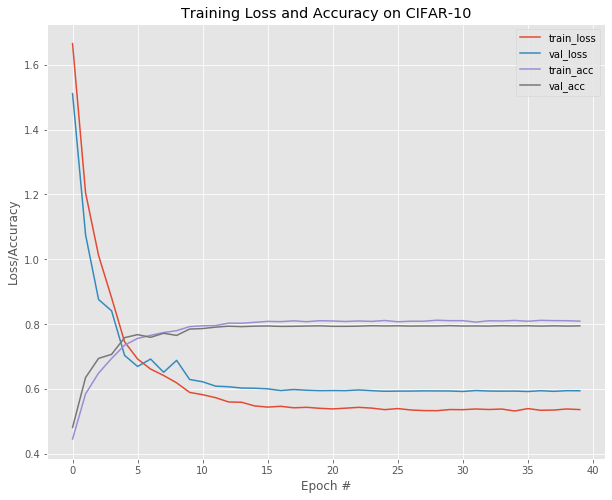

In [18]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [19]:
def half_step_decay(epoch):
    # initialize the base initial learning rate, drop factor, and
    # epochs to drop every
    initAlpha = 0.01
    factor = 0.25
    dropEvery = 5
    
    # compute learning rate for the current epoch
    alpha = initAlpha * (factor ** np.floor((1 + epoch) / dropEvery))
    
    # return the learning rate
    return float(alpha)

In [20]:
# define the set of callbacks to be passed to the model during training
callbacks = [LearningRateScheduler(half_step_decay)]

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.01, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=40, callbacks=callbacks, verbose=1)

[INFO] compiling model...
[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 12s 233us/step - loss: 1.6608 - acc: 0.4491 - val_loss: 1.2706 - val_acc: 0.5594
Epoch 2/40
50000/50000 [==============================] - 11s 215us/step - loss: 1.1744 - acc: 0.5969 - val_loss: 0.9270 - val_acc: 0.6830
Epoch 3/40
50000/50000 [==============================] - 11s 215us/step - loss: 0.9793 - acc: 0.6604 - val_loss: 0.8699 - val_acc: 0.6920
Epoch 4/40
50000/50000 [==============================] - 11s 218us/step - loss: 0.8739 - acc: 0.6958 - val_loss: 0.7449 - val_acc: 0.7354
Epoch 5/40
50000/50000 [==============================] - 11s 219us/step - loss: 0.7229 - acc: 0.7460 - val_loss: 0.6606 - val_acc: 0.7679
Epoch 6/40
50000/50000 [==============================] - 11s 219us/step - loss: 0.6718 - acc: 0.7640 - val_loss: 0.6466 - val_acc: 0.7749
Epoch 7/40
50000/50000 [==============================] - 11s 2

In [21]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

    airplane       0.83      0.79      0.81      1000
  automobile       0.91      0.88      0.90      1000
        bird       0.74      0.66      0.70      1000
         cat       0.66      0.61      0.63      1000
        deer       0.73      0.80      0.76      1000
         dog       0.73      0.73      0.73      1000
        frog       0.79      0.90      0.84      1000
       horse       0.86      0.83      0.85      1000
        ship       0.88      0.89      0.89      1000
       truck       0.85      0.89      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



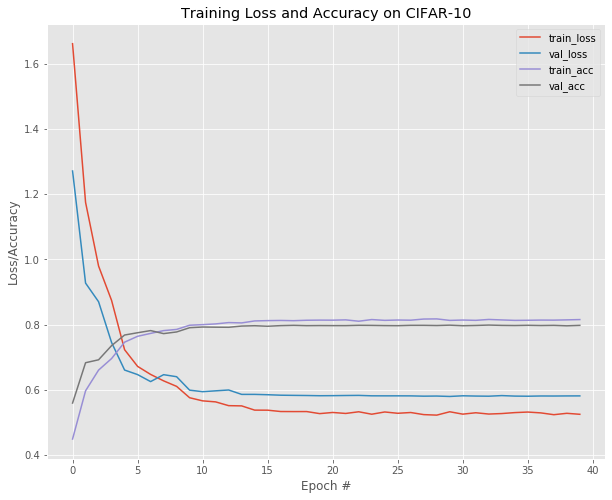

In [22]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()